In [1]:
import collections
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('../data/twitter_sentiment_analysis_data_raw.csv', encoding='latin-1', names=['label', 'id', 'data', 'query', 'author', 'tweet'])

In [3]:
data.head()

,label,id,data,query,author,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data.loc[data['label']==4, 'label'] = 1
data.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [5]:
re_punctuations = """,|'|\.|!|\?|&|"|:|[|]|;|quot|\\/|ing|\\(|\\)"""
data['adjusted_tweets'] = data.tweet.str.lower().str.replace(re_punctuations, '', regex=True)
data.head()

,label,id,data,query,author,tweet,adjusted_tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",@switchfoot httptwitpiccom2y1zl - awww thats a...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan i dived many times for the ball mana...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",@nationwideclass no its not behav at all im ma...


# Sampled data

In [6]:
df = data.groupby('label').head(1250).reset_index(drop=True)

In [7]:
df.label.value_counts()

0    1250
1    1250
Name: label, dtype: int64

In [8]:
df.head()

,label,id,data,query,author,tweet,adjusted_tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",@switchfoot httptwitpiccom2y1zl - awww thats a...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan i dived many times for the ball mana...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",@nationwideclass no its not behav at all im ma...


In [9]:
train, test = train_test_split(df, test_size=0.7, random_state=42)

In [10]:
train.head()

,label,id,data,query,author,tweet,adjusted_tweets
132,0,1467842107,Mon Apr 06 22:28:02 PDT 2009,NO_QUERY,wiccabuffy,"@Knights_ No, no notice. They told me I'd be w...",@knights_ no no notice they told me id be work...
80,0,1467834053,Mon Apr 06 22:25:52 PDT 2009,NO_QUERY,thelazyboy,sleep soon... i just hate saying bye and see y...,sleep soon i just hate say bye and see you tom...
1586,1,1467881695,Mon Apr 06 22:38:24 PDT 2009,NO_QUERY,JonLanderos,"Ahh, the tedium of fixing broken file links in...",ahh the tedium of fix broken file links in inv...
2157,1,1467987805,Mon Apr 06 23:08:11 PDT 2009,NO_QUERY,Tarale,Had a great lunch with one of my &quot;mums&qu...,had a great lunch with one of my mums today @c...
758,0,1467999499,Mon Apr 06 23:11:30 PDT 2009,NO_QUERY,jj_1983,Back at work @ John Muir Dr http://loopt.us/K...,back at work @ john muir dr httplooptuskoqabg


In [11]:
def txt_to_list(file_name):
    my_file = open(file_name, "r", encoding="utf8")
    content_list = [line.rstrip('\n') for line in my_file.readlines()]
    return content_list

def build_vocabularies(data, label_col, sentence_col):
    stop_words = txt_to_list('data/stopwords.txt')
    
    pos_vocabulary = [
        word
        for tweet in data.loc[data[label_col]==1, sentence_col].values.tolist() 
        for word in tweet.split(' ') 
        if len(word) > 1 
        and '@' not in word 
        and re.sub(re_punctuations,'', word) not in stop_words 
        and 'www' not in word
        and 'http' not in word
        and '.com' not in word
    ]
    
    neg_vocabulary = [
        word
        for tweet in data.loc[data[label_col]==0, sentence_col].values.tolist() 
        for word in tweet.split(' ') 
        if len(word) > 1 
        and '@' not in word 
        and re.sub(re_punctuations,'', word) not in stop_words 
        and 'www' not in word
        and 'http' not in word
        and '.com' not in word
    ]

    return pos_vocabulary, neg_vocabulary    

In [12]:
pos_vocabulary, neg_vocabulary = build_vocabularies(train, 'label', 'adjusted_tweets')
neg_freq = collections.Counter(x for x in neg_vocabulary)
pos_freq = collections.Counter(x for x in pos_vocabulary)

In [13]:
neg_freq

Counter({'notice': 1,
         'told': 2,
         'tomorrow': 13,
         'called': 5,
         'agency': 2,
         'follow': 2,
         'sleep': 20,
         'hate': 5,
         'bye': 1,
         'night': 9,
         'john': 1,
         'muir': 1,
         'dr': 1,
         'sucks': 2,
         'listen': 3,
         'xbox': 1,
         '360': 1,
         'fancast': 1,
         'tonite': 2,
         'pretty': 3,
         'favenot': 1,
         'reason': 2,
         'watch': 9,
         'concentrate': 1,
         'stuck': 2,
         'awake': 2,
         'middle': 3,
         'day': 22,
         'row': 1,
         'terrible': 2,
         'yesterday': 3,
         'bff': 1,
         'reminds': 1,
         'lt3': 3,
         'shout': 2,
         'courts': 1,
         'nasty': 1,
         'budget': 1,
         'iphone': 2,
         'apple': 1,
         'pet': 1,
         'care': 3,
         'people': 3,
         'business': 2,
         'send': 2,
         'suspicious': 1,
         'e-

In [14]:
def calculate_scores(sentence, pos_frequency_dict=pos_freq, neg_frequency_dict=neg_freq):
    words_list = sentence.split(' ')
    pos_value = 0
    neg_value = 0
    for word in words_list:
        pos_value += pos_frequency_dict[word]
        neg_value += neg_frequency_dict[word]
    return pos_value, neg_value        

In [15]:
train[["pos_value", "neg_value"]] = train["adjusted_tweets"].map(calculate_scores).tolist()
test[["pos_value", "neg_value"]] = test["adjusted_tweets"].map(calculate_scores).tolist()

In [16]:
test.head()

,label,id,data,query,author,tweet,adjusted_tweets,pos_value,neg_value
1447,1,1467861286,Mon Apr 06 22:32:57 PDT 2009,NO_QUERY,llliizzziiiee,@Westneyrhindxx hello westney what are you do...,@westneyrhindxx hello westney what are you do x,0,0
1114,0,1468083884,Mon Apr 06 23:37:29 PDT 2009,NO_QUERY,pstannard1,"got woken up this mornng at 7am - damn Lorry ,...",got woken up this mornng at 7am - damn lorry ...,2,12
1064,0,1468072530,Mon Apr 06 23:33:55 PDT 2009,NO_QUERY,SarahDeG,Why do I keep looking...I know that what I rea...,why do i keep looki know that what i read is g...,24,15
2287,1,1468007017,Mon Apr 06 23:13:40 PDT 2009,NO_QUERY,Hetty4Christ,Pray for my friend @growline late work...pray ...,pray for my friend @growline late workpray it ...,13,5
1537,1,1467864444,Mon Apr 06 22:33:48 PDT 2009,NO_QUERY,elysemize,@JonathanRKnight i do embrace the simple life...,@jonathanrknight i do embrace the simple life...,25,18


In [17]:
features = ['pos_value', 'neg_value']

X_train, y_train = train[features].to_numpy(), train['label'].to_numpy()
X_test, y_test = test[features].to_numpy(), test['label'].to_numpy()

In [18]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
h_params = {'penalty': 'l2', 'max_iter': 100, 'random_state': 42}
clf = LogisticRegression(**h_params)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

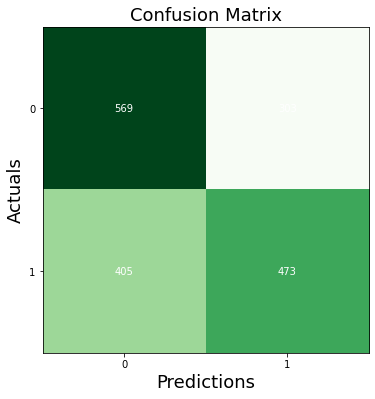

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [21]:
logreg=accuracy_score(y_test, y_pred)
logreg

0.5954285714285714

In [22]:
roc_auc_score(y_test, y_pred)

0.5956236546780632

In [23]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.65      0.62       872
           1       0.61      0.54      0.57       878

    accuracy                           0.60      1750
   macro avg       0.60      0.60      0.59      1750
weighted avg       0.60      0.60      0.59      1750



# Using all data

In [24]:
df = data
df.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [25]:
train, test = train_test_split(df, test_size=0.7, random_state=42)

pos_vocabulary, neg_vocabulary = build_vocabularies(train, 'label', 'adjusted_tweets')
neg_freq = collections.Counter(x for x in neg_vocabulary)
pos_freq = collections.Counter(x for x in pos_vocabulary)

train['adjusted_tweets'] = train.tweet.str.lower().str.replace(re_punctuations, '', regex=True)
test['adjusted_tweets'] = test.tweet.str.lower().str.replace(re_punctuations, '', regex=True)

In [26]:
train[["pos_value", "neg_value"]] = train["adjusted_tweets"].map(calculate_scores).tolist()
test[["pos_value", "neg_value"]] = test["adjusted_tweets"].map(calculate_scores).tolist()

In [27]:
features = ['pos_value', 'neg_value']

X_train, y_train = train[features].to_numpy(), train['label'].to_numpy()
X_test, y_test = test[features].to_numpy(), test['label'].to_numpy()

In [28]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [29]:
h_params = {'penalty': 'l2', 'max_iter': 200, 'random_state': 42}
clf = LogisticRegression(**h_params)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

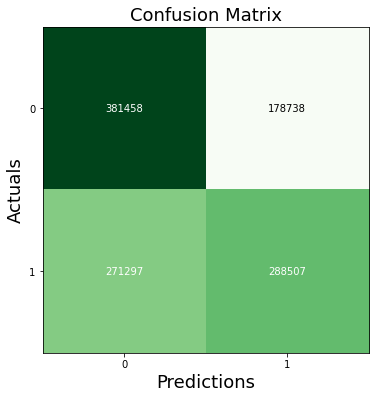

In [30]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [31]:
logreg=accuracy_score(y_test, y_pred)
logreg

0.5981830357142857

In [32]:
roc_auc_score(y_test, y_pred)

0.5981540618006582

In [33]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.68      0.63    560196
           1       0.62      0.52      0.56    559804

    accuracy                           0.60   1120000
   macro avg       0.60      0.60      0.60   1120000
weighted avg       0.60      0.60      0.60   1120000

